<a href="https://colab.research.google.com/github/dkalenov/TMDB-Movie-Data-Analysis/blob/main/TMDB_Movie_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Movie analysis based on data from the TMDB website**



---


Project objectives


1) **Hypothesis 1**: the more films are released per year, the more “dollar billionaires” there are among them.

Tasks:
- Sort films that have grossed more than a billion US dollars by year of release, count their number per year;
Determine the total number of films released in those years when at least one billion-dollar film was released;
Establish the dependence of the number of “billionaire films” on the total number of films released.

2) **Hypothesis 2**: The biggest profits in absolute and relative terms come from action films.

Tasks:
- Sort films by genre and calculate average profit;
Find total profit and by genre;
Determine what place in the ranking of overall genre profits are films of the “action” genre;
Calculate the total number of films released by genre and calculate the profit percentage;

3) **Hypothesis 3:** Remakes of films that have the same name as the original bring more profit than the original itself.

Tasks:
- Sort films that have the same title but different release dates;
Compare the average box office receipts of similar films in absolute and relative terms.



---



## Functions for data processing and EDA

In [1]:
# Function for displaying basic information about the dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def basic_data_preprocessing(dataframe):
    # Convert all column titles to lowercase with "_" between words
    dataframe.columns = [x.lower().replace(' ', '_') for x in dataframe.columns.values]

    # Basic information about the dataset
    rows_num, columns_num = dataframe.shape
    print(f'Number of records: {rows_num}')
    print(f'Number of columns: {columns_num}\n')
    print('-' * 75)

    # Dataset information
    print("\nDataset Information:")
    display(dataframe.info())
    print()
    print('-' * 75)

    # Checking for missing values
    missing_values = dataframe.isnull().sum()
    if missing_values.sum() > 0:
        print("Missing values:")
        display(pd.DataFrame(missing_values, columns=['Missing Count']))
        display(dataframe[dataframe.isna().any(axis=1)])
    else:
        print("No missing values.")
    print('-' * 75)

    # Checking for zero-filled columns
    zero_columns = dataframe.columns[(dataframe == 0.0).any()]
    zero_count = dataframe[zero_columns].apply(lambda x: x.value_counts().get(0, 0))
    if zero_count.sum() != 0:
        print('Rows with value 0 found:')
        display(pd.DataFrame(zero_count, columns=['Zero Count']))
    else:
        print('No rows with value 0.')
    print('-' * 75)

    # Checking for duplicates
    if dataframe.duplicated().sum() > 0:
        print("Duplicate data found. Number of duplicates:", dataframe.duplicated().sum())
        display(dataframe[dataframe.duplicated(keep=False)])
    else:
        print("No duplicates found.")
    print('-' * 75)

    # Checking for negative values in the dataframe
    # Excluding columns with string data type (object type)
    dataframe_digits = dataframe.select_dtypes(exclude=['object'])
    if (dataframe_digits < 0).sum().sum() > 0:
        print("Negative values found:")
        display(pd.DataFrame((dataframe_digits < 0).sum(), columns=['Negative Value Count']))
    else:
        print('No negative values found.')
    print('-' * 75)

    # Statistical description of the data
    print("\nStatistical Description of the Data:\n")
    display(dataframe.describe())
    print('-' * 75)

In [2]:
# Function for compression of the data type of columns in a pandas DataFrame

import pandas as pd
import numpy as np

def data_type_compression(dataframe):

    for column in dataframe.columns:
        unique_values = dataframe[column].unique()

        # Check if the column has two unique values (potentially a boolean column)
        # Uncomment the code below if you want to convert such columns to boolean type
        # if len(unique_values) == 2:
        #   dataframe[column] = dataframe[column].astype(bool)

        # Check if the column has an integer data type
        if dataframe[column].dtype == int:
            max_value = np.max(dataframe[column])

            # Assign the appropriate integer type based on the maximum value in the column
            if max_value <= np.iinfo(np.int8).max:
                dataframe[column] = dataframe[column].astype(np.int8)
            elif max_value <= np.iinfo(np.int16).max:
                dataframe[column] = dataframe[column].astype(np.int16)
            elif max_value <= np.iinfo(np.int32).max:
                dataframe[column] = dataframe[column].astype(np.int32)
            else:
                dataframe[column] = dataframe[column].astype(np.int64)

        # Check if the column has a float data type
        elif dataframe[column].dtype == float:
            max_value = np.max(dataframe[column])

            # Assign the appropriate float type based on the maximum value in the column
            if max_value <= np.finfo(np.float16).max:
                dataframe[column] = dataframe[column].astype(np.float16)
            elif max_value <= np.finfo(np.float32).max:
                dataframe[column] = dataframe[column].astype(np.float32)
            else:
                dataframe[column] = dataframe[column].astype(np.float64)

In [3]:
# Function for visualizing the distribution of different features by a target feature

import matplotlib.pyplot as plt
import seaborn as sns

def data_distribution_by_target(dataframe, target_feature):
    for column in dataframe.columns:
        if column != target_feature:
            # Create a new figure with size (8, 6)
            plt.figure(figsize=(8, 6))

            # Set style for grid (white with no grid lines)
            sns.set_style("whitegrid", {'axes.grid': False})

            # Categorical feature: barplot
            if dataframe[column].dtype == 'object':
                #plt.xticks(rotation=45, ha='right')
                plot = sns.barplot(x=column, y=target_feature, data=dataframe)

            # Date/time feature: lineplot
            elif dataframe[column].dtype == 'datetime64[ns]':
                plt.xticks(rotation=45, ha='right')
                plot = sns.lineplot(x=column, y=target_feature, data=dataframe)

            # Boolean feature: barplot
            elif dataframe[column].dtype == 'bool':
                plt.xticks([0, 1], ['False', 'True'])
                #plt.xticks(rotation=45, ha='right')
                plot = sns.barplot(x=column, y=target_feature, data=dataframe)

            # Numeric feature: histogram with kernel density estimation (kde)
            elif dataframe[column].dtype in ['float64', 'float32', 'float16']:
                # Determine the number of bins for the histogram
                n_bins = min(30, len(dataframe[column].unique()))
                # Calculate the bin width and range
                binwidth = (dataframe[column].max() - dataframe[column].min()) / n_bins
                binrange = (dataframe[column].min(), dataframe[column].max())
                # Create a histogram with KDE
                sns.histplot(data=dataframe, x=column, bins=n_bins, binwidth=binwidth, binrange=binrange, kde=True, cumulative=False)
                plt.axvline(x=dataframe[column].mean(), color='r', linestyle='--', linewidth=2)   # Add a vertical line at the mean value
                #plt.xticks(rotation=45, ha='right')

            # Other feature types: scatterplot with regression line or countplot
            else:
                if dataframe[column].nunique() > 6:
                    # Create a scatterplot with regression line
                    plot = sns.scatterplot(data=dataframe, x=column, y=target_feature, alpha=0.7)
                    sns.regplot(data=dataframe, x=column, y=target_feature, scatter=False, lowess=True, line_kws={"color": "C1"})
                    # plt.xticks(rotation=45, ha='right')
                    plt.axvline(x=dataframe[column].mean(), color='r', linestyle='--', linewidth=2)
                else:
                    # Create a countplot
                    plot = sns.countplot(data=dataframe, x=column, y=target_feature)

            plot.set_title(f'Data Distribution by {target_feature}: {column}')  # Set title
            plot.set_xlabel(column)  # Set x-axis label
            plot.set_ylabel(target_feature)  # Set y-axis label
            plt.tight_layout() # Adjust plot layout
            plt.show()

# EDA

In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import pandas as pd

url = 'https://raw.githubusercontent.com/dkalenov/TMDB-Movie-Data-Analysis/main/movies_tmdb.csv'
data = pd.read_csv(url)
data.head(3)

,Unnamed: 0,id,title,release_date,genres,original_language,vote_average,vote_count,popularity,overview,budget,production_companies,revenue,runtime,tagline
0,0,385687,Fast X,2023-05-17,"['Action', 'Crime', 'Thriller']",English,7.4,1347.0,8363.473,Over many missions and against impossible odds...,340000000.0,"['Universal Pictures', 'Original Film', 'One R...",6.520000e+08,142.0,The end of the road begins.
1,1,603692,John Wick: Chapter 4,2023-03-22,"['Action', 'Thriller', 'Crime']",English,7.9,2896.0,4210.313,"With the price on his head ever increasing, Jo...",90000000.0,"['Thunder Road', '87Eleven', 'Summit Entertain...",4.317692e+08,170.0,"No way back, one way out."
2,2,502356,The Super Mario Bros. Movie,2023-04-05,"['Animation', 'Family', 'Adventure', 'Fantasy'...",English,7.8,4628.0,3394.458,"While working underground to fix a water main,...",100000000.0,"['Universal Pictures', 'Illumination', 'Ninten...",1.308767e+09,92.0,NaN


In [7]:
df = data.copy()

In [8]:
# Remove columns unnecessary for analysis

df.drop(['Unnamed: 0','overview','tagline', 'original_language'], axis=1, inplace=True)

In [9]:
basic_data_preprocessing(df)

Number of records: 10001
Number of columns: 11

---------------------------------------------------------------------------

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10001 non-null  int64  
 1   title                 10001 non-null  object 
 2   release_date          9978 non-null   object 
 3   genres                10001 non-null  object 
 4   vote_average          10000 non-null  float64
 5   vote_count            10000 non-null  float64
 6   popularity            10000 non-null  float64
 7   budget                9999 non-null   float64
 8   production_companies  9999 non-null   object 
 9   revenue               9999 non-null   float64
 10  runtime               9999 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 859.6+ KB


None


---------------------------------------------------------------------------
Missing values:


,Missing Count
id,0
title,0
release_date,23
genres,0
vote_average,1
vote_count,1
popularity,1
budget,2
production_companies,2
revenue,2


,id,title,release_date,genres,vote_average,vote_count,popularity,budget,production_companies,revenue,runtime
225,619329,Munthiri Kaadu,2023-04-07,"['Drama', 'Action']",4.3,3.0,126.896,NaN,NaN,NaN,NaN
226,0,['Aathi Thiraikalam'],0,178,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1073,626412,Alienoid: Part 2,NaN,[],0.0,0.0,47.439,0.0,['Caper Film'],0.0,0.0
1299,1034541,Terrifier 3,NaN,"['Horror', 'Fantasy', 'Thriller']",0.0,0.0,41.450,0.0,"['Dark Age Cinema', 'Fuzz on the Lens Producti...",0.0,0.0
1538,421892,Shrek 5,NaN,"['Animation', 'Family', 'Comedy', 'Fantasy']",0.0,0.0,37.458,0.0,['DreamWorks Animation'],0.0,0.0
1594,969681,Spider-Man 4,NaN,['Action'],0.0,0.0,36.681,0.0,"['Marvel Studios', 'Columbia Pictures', 'Pasca...",0.0,0.0
1643,1108427,Moana,NaN,"['Adventure', 'Comedy', 'Family', 'Fantasy']",0.0,0.0,35.976,0.0,"['Walt Disney Pictures', 'Seven Bucks Producti...",0.0,0.0
2217,1126217,Fast X: Part 3,NaN,[],0.0,0.0,30.089,0.0,[],0.0,0.0
2705,631969,Kingsman: The Blue Blood,NaN,"['Action', 'Comedy', 'Adventure']",0.0,0.0,26.741,0.0,"['Marv Films', '20th Century Studios']",0.0,0.0
2738,730629,John Wick: Chapter 5,NaN,"['Action', 'Adventure', 'Crime', 'Thriller']",0.0,0.0,26.483,0.0,"['Summit Entertainment', 'Thunder Road']",0.0,0.0


---------------------------------------------------------------------------
Rows with value 0 found:


,Zero Count
id,1
vote_average,290
vote_count,289
budget,4649
revenue,4395
runtime,175


---------------------------------------------------------------------------
No duplicates found.
---------------------------------------------------------------------------
No negative values found.
---------------------------------------------------------------------------

Statistical Description of the Data:



,id,vote_average,vote_count,popularity,budget,revenue,runtime
count,1.000100e+04,10000.000000,10000.000000,10000.000000,9.999000e+03,9.999000e+03,9999.000000
mean,3.001465e+05,6.319090,1558.294800,33.542340,1.993800e+07,6.084337e+07,100.809581
std,3.379901e+05,1.460605,2887.861217,126.495621,3.870582e+07,1.553073e+08,27.850165
min,0.000000e+00,0.000000,0.000000,12.297000,0.000000e+00,0.000000e+00,0.000000
25%,1.150400e+04,5.900000,143.000000,14.599000,0.000000e+00,0.000000e+00,90.000000
50%,1.184060e+05,6.600000,519.000000,18.582500,1.250000e+06,2.133452e+06,100.000000
75%,5.379150e+05,7.100000,1584.000000,28.014500,2.300000e+07,5.106230e+07,115.000000
max,1.136631e+06,10.000000,33822.000000,8363.473000,4.600000e+08,2.923706e+09,366.000000


---------------------------------------------------------------------------


In [10]:
# compress int and float data
data_type_compression(df)

In [13]:
df.head(3)

,id,title,release_date,genres,vote_average,vote_count,popularity,budget,production_companies,revenue,runtime
0,385687,Fast X,2023-05-17,"['Action', 'Crime', 'Thriller']",7.398438,1347.0,8360.0,340000000.0,"['Universal Pictures', 'Original Film', 'One R...",6.520000e+08,142.0
1,603692,John Wick: Chapter 4,2023-03-22,"['Action', 'Thriller', 'Crime']",7.898438,2896.0,4212.0,90000000.0,"['Thunder Road', '87Eleven', 'Summit Entertain...",4.317692e+08,170.0
2,502356,The Super Mario Bros. Movie,2023-04-05,"['Animation', 'Family', 'Adventure', 'Fantasy'...",7.800781,4628.0,3394.0,100000000.0,"['Universal Pictures', 'Illumination', 'Ninten...",1.308767e+09,92.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10001 non-null  int32  
 1   title                 10001 non-null  object 
 2   release_date          9978 non-null   object 
 3   genres                10001 non-null  object 
 4   vote_average          10000 non-null  float16
 5   vote_count            10000 non-null  float16
 6   popularity            10000 non-null  float16
 7   budget                9999 non-null   float32
 8   production_companies  9999 non-null   object 
 9   revenue               9999 non-null   float32
 10  runtime               9999 non-null   float16
dtypes: float16(4), float32(2), int32(1), object(4)
memory usage: 508.0+ KB


According to data profiling:
- Number of lines: 10,001; number of columns: 11;
- The total number of passes is 33, which is less than 0.1%. Most gaps (23) in the 'release_date' column, 1 gap in the 'vote_average' column, 'vote_count' - 1, 'budget' - 2, 'production_companies' - 2, 'revenue' - 2, 'runtime' - 2;
- No duplicates found.

Format the dataframe: remove gaps, remove unnecessary information from rows, format row values.


In [14]:
# Remove all NaN lines with

df.dropna(inplace=True)

In [15]:
# Remove the time value from the release_date column, leaving only the release date

#in the release_date column the values could not be converted directly into date format, so I had to use
#argument errors='coerce' to pd.to_datetime(), which converts incorrect values to NaT (Not a Time) value
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

#extract only the date from the converted values
df['release_date'] = df['release_date'].dt.date

In [16]:
# Convert the data in the 'vote_count' column to the int type

df['vote_count'] = df['vote_count'].astype(int)

In [17]:
df.head(3)

,id,title,release_date,genres,vote_average,vote_count,popularity,budget,production_companies,revenue,runtime
0,385687,Fast X,2023-05-17,"['Action', 'Crime', 'Thriller']",7.398438,1347,8360.0,340000000.0,"['Universal Pictures', 'Original Film', 'One R...",6.520000e+08,142.0
1,603692,John Wick: Chapter 4,2023-03-22,"['Action', 'Thriller', 'Crime']",7.898438,2896,4212.0,90000000.0,"['Thunder Road', '87Eleven', 'Summit Entertain...",4.317692e+08,170.0
2,502356,The Super Mario Bros. Movie,2023-04-05,"['Animation', 'Family', 'Adventure', 'Fantasy'...",7.800781,4628,3394.0,100000000.0,"['Universal Pictures', 'Illumination', 'Ninten...",1.308767e+09,92.0


In [18]:
df.info() # display information on the dataset for checking before loading into bd

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9976 entries, 0 to 10000
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    9976 non-null   int32  
 1   title                 9976 non-null   object 
 2   release_date          9976 non-null   object 
 3   genres                9976 non-null   object 
 4   vote_average          9976 non-null   float16
 5   vote_count            9976 non-null   int64  
 6   popularity            9976 non-null   float16
 7   budget                9976 non-null   float32
 8   production_companies  9976 non-null   object 
 9   revenue               9976 non-null   float32
 10  runtime               9976 non-null   float16
dtypes: float16(3), float32(2), int32(1), int64(1), object(4)
memory usage: 901.0+ KB


## Connect to db

In [ ]:
# Connect to db in SQLite

con = sqlite3.connect(r'E:\MathsHub\SQL\sql project\tmdb_movies', timeout=10)
cur = con.cursor()

In [ ]:
# Add a table to db

df.to_sql(con=con, name='movies_table', index=False, if_exists='replace')

# Hypothesis 1


The more films are released per year, the more “dollar billionaires” there are among them

In [ ]:
# list the rating of films that have grossed more than a billion US dollars

top_boxoffice = '''
SELECT
  ROW_NUMBER() OVER(ORDER BY revenue DESC) AS rating, title, revenue
  FROM movies_table
  WHERE revenue >= 1000000000'''


cur.execute(top_boxoffice )
con.commit()
cur.fetchall()

In [ ]:
# Sorting billionaire films by year of release and their number per year

top_boxoffice_count = '''
SELECT
    COUNT(title) AS movies_count,
    strftime("%Y", release_date) AS year,
    SUM(COUNT(title)) OVER(ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_amount
    FROM movies_table
    WHERE revenue >= 1000000000 GROUP BY year '''


cur.execute(top_boxoffice_count)
rows = cur.fetchall()
pd.DataFrame(rows, columns = ('movies_count', 'year', 'total_amount'))

In [ ]:
# Total number of films released in a year in which at least one billionaire film was released

year_movie_count = '''
      CHOOSE
          strftime("%Y", Release_date) Year AS,
          COUNT(name) AS Movies_count
      FROM movies_table
      WHERE strftime("%Y", Release_date) IN (SELECT strftime("%Y", Release_date) FROM Movies_table WHERE revenue >= 1000000000)
      GROUP BY YEAR
      '''

cur.execute(year_movie_count)
strings = cur.fetchall()
pd.DataFrame(rows, columns = ('year', 'movies_count'))

# Conclusion:
- From 1997 to 2009, there was a twofold increase in the number of films released per year, while the number of “billionaire films” did not increase.
- From 2009 to 2012, the number of “billionaire films” increased by one every year, while the total number of films increased slightly. In 2012, 4 “billionaire films” were released, but compared to 2011, 14 fewer were released in 2012.
- In 2013 and 2014, against the backdrop of an increase in the total number of released films, there was a decrease in the number of films that grossed a billion or more.
- From 2015 to 2019, there was a sharp increase in the number of “billionaire films”, reaching a maximum of 9 films in history. The total number of films also gradually increased.
- After the pandemic period in 2021, the trend towards an increase in the total number of films continues, but there are only 1 “billionaire films” among them.
- In 2022, a record number of films were released in total - 825 films, 3 of them were “billionaire films”, as in 2011, when the total number of films was 3 times less, only 261.

- Thus, the number of films released is not a factor in the increase in the number of “millionaire films” released. On the contrary, statistics for 2013, 2014, 2021, 2022 show an inverse relationship.


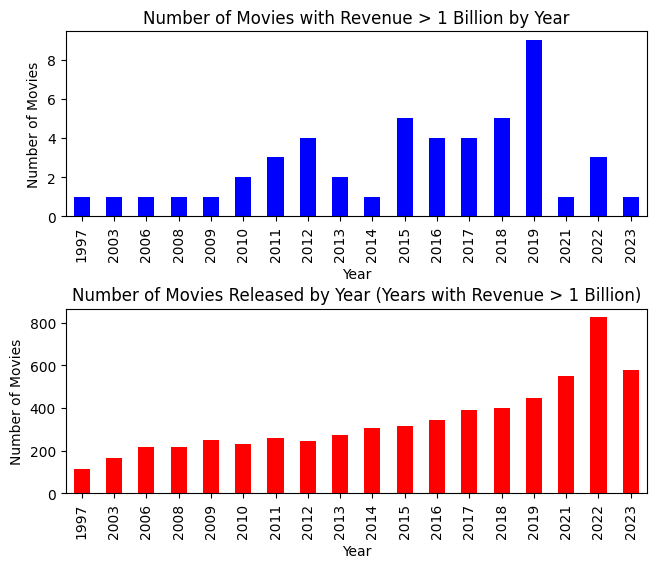

In [19]:
# Output graphs for data visualization

get_ipython().run_line_magic('matplotlib', 'inline')

# create a copy of the table
df_top_movies = df.copy()

# Code for the first chart
df_top_movies['release_date'] = pd.to_datetime(df['release_date']) # set release_date to date format
df_top_movies['year'] = df_top_movies['release_date'].dt.year # leave only the year, create a year column

revenue_max = df_top_movies[df_top_movies['revenue'] > 1000000000] # select films with gross receipts above 1000000000
movies_count = revenue_max.groupby('year').size() # group by year column


# First chart
plt.subplot(2, 1, 1) # will display the plot on top
movies_count.plot(kind='bar', color='blue', figsize=(7.5, 6))
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies with Revenue > 1 Billion by Year')
plt.grid(False) # removes the grid from the graph

# Code for the second chart
filtered_year = df_top_movies[df_top_movies['year'].isin(revenue_max['year'].unique())]
movies_count_filtered = filtered_year.groupby('year').size()

# Second chart
plt.subplot(2, 1, 2)# will display the plot below
movies_count_filtered.plot(kind='bar', color='red')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies Released by Year (Years with Revenue > 1 Billion)')
plt.grid(False)

plt.subplots_adjust(hspace=0.5)
plt.show()

# Hypothesis 2

The biggest profits in quantitative and percentage terms come from action films